In [129]:
import tensorflow as tf
import glob
import os

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_train\*.png"))
seg_train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_train\*.png"))

test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_test\*.png"))
seg_test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_test\*.png"))

val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_validate\*.png"))
seg_val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_validate\*.png"))

In [130]:
train = tf.data.Dataset.from_tensor_slices(train_dir)
test = tf.data.Dataset.from_tensor_slices(test_dir)
val = tf.data.Dataset.from_tensor_slices(val_dir)

train = train.shuffle(len(train_dir))
test = test.shuffle(len(test_dir))
val = val.shuffle(len(val_dir))

def process_path(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (256,256))
    img = tf.cast(img, tf.float32) - 127.5
    img = img / 127.5

    return img

train = train.map(process_path).batch(16)
test = test.map(process_path).batch(16)
val = val.map(process_path).batch(16)

train_count = 0
test_count = 0

# for i in train:
#     train_count += 1
# for i in test:
#     test_count += 1
    
print(train, test, "Train Count: ", train_count, "Test Count: ", test_count)

<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32> <BatchDataset shapes: (None, 256, 256, 1), types: tf.float32> Train Count:  0 Test Count:  0


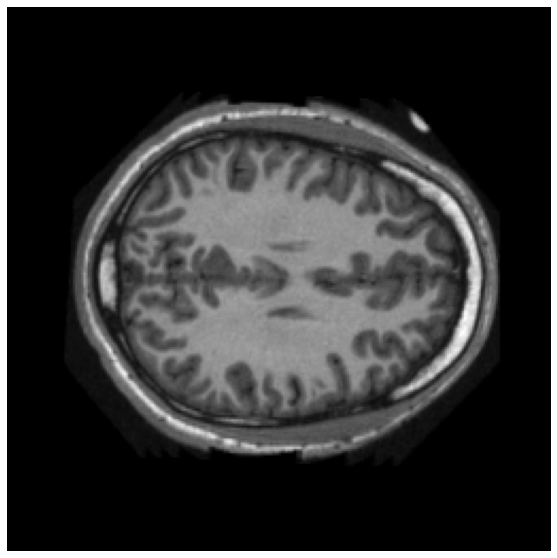

In [133]:
import matplotlib.pyplot as plt 

def display(images):
    plt.figure(figsize=(10,10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.show()
    
for img in train.take(1):
    display([tf.squeeze(img[0])])

In [134]:
from tensorflow.keras import layers

image_res = (256,256)

def make_generator_model():
    model = tf.keras.Sequential()
        
    model.add(layers.Dense(image_res[0] // 8 * image_res[1] // 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_res[0] // 8, image_res[1] // 8, 256)))
    
    assert model.output_shape == (None, image_res[0] // 8, image_res[1] // 8, 256)

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 4, image_res[1] // 4, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 2, image_res[1] // 2, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    assert model.output_shape == (None, image_res[0], image_res[1], 1)
    
#     model.summary()
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[image_res[0], image_res[1], 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
#     model.summary()
    return model

In [145]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [146]:
generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_prefix = os.path.join('./checkpoints/', "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [147]:
seed = tf.random.normal([16, 100])
@tf.function
def train_step(images):
    noise = tf.random.normal([16, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [158]:
from IPython import display

def load_checkpoint():
    checkpoint.restore(tf.train.latest_checkpoint('./checkpoints/'))
    
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    
    prediction = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [159]:
import time

def train_model(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

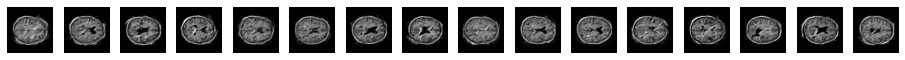

Time for epoch 1 is 51.72746205329895 sec


KeyboardInterrupt: 

In [160]:
train_model(train, 50)